In [1]:
%matplotlib inline

## Imports

In [26]:
import os
import numpy as np
from random import sample, seed
seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import get_file

#read all images (jpg, png) in imgDirPath and resize to 227x227
def readImagesFromDir(imgDirPath):
    fileNames = os.listdir(imgDirPath)
    imagePaths = [os.path.join(imgDirPath,img) for img in fileNames if img[-3:] in ['jpg', 'png']]
    imageList = [load_img(img, target_size=(227, 227)) for img in imagePaths]
    imageList = [img_to_array(img) for img in imageList]
    return imageList, fileNames

#plot the first 9 images from imgList
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

# Fire Module
<img src="./fireModule.png" width=50% height=50%>

In [29]:
# Fire Module Definition

def fire_module(x, fire_id, squeeze=16, expand=64):
    id_prefix = f'fire_{fire_id}'
    
    squeeze = Convolution2D(squeeze, kernel_size=(1,1), padding='same', activation='relu', name=f'{id_prefix}/squeeze1x1')(x)
    expand1x1 = Convolution2D(expand, kernel_size=(1,1), padding='same', activation='relu', name=f'{id_prefix}/expand1x1')(squeeze)
    expand3x3 = Convolution2D(expand, kernel_size=(3,3), padding='same', activation='relu', name=f'{id_prefix}/expand3x3')(squeeze)
    concat = concatenate([expand1x1, expand3x3], axis=3, name=f'{id_prefix}/concat')
    
    return concat

# SqueezeNet
<img src="squeezeNet.png">

In [31]:
#SqueezeNet model definition
def SqueezeNet(input_shape, classes=1000):
    img_input = Input(shape=input_shape) #placeholder
    
    #define the rest of the architecture
    x = Convolution2D(64, kernel_size=(3,3), strides=(2,2), padding='valid', activation='relu', name='conv1')(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), name='pool1')(x)
    
    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), name='pool3')(x)
    
    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), name='pool5')(x)
    
    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)
    
    x = Convolution2D(classes, kernel_size=(1,1), padding='valid', activation='relu', name='conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)
    
    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

Now that our architecture is defined, let's create a model. It will take some time to download and load the weights, but once it is finished, we will see the model summary.

In [32]:
squeezeNetModel = SqueezeNet((227,227,3))
print(squeezeNetModel.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 113, 113, 64) 1792        input_12[0][0]                   
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 56, 56, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire_2/squeeze1x1 (Conv2D)      (None, 56, 56, 16)   1040        pool1[0][0]                      
__________________________________________________________________________________________________
fire_2/exp

# Evaluation
We have shared with you some images from [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), a competition of object classification with a huge collection of images comprising 1000 classes (that is why our network outputs predictions of size 1000). Most recent architectures are pre-trained in ImageNet and have their weights available online. 

We will load the images from the `./images` folder, pre-process them and let our SqueezeNet model predict their classes. **You can add or remove images from `./images` to test the network by yourself.** 

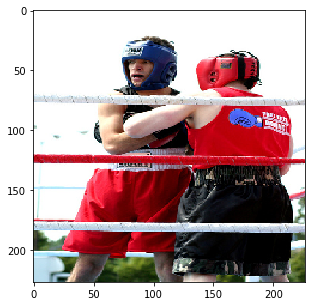

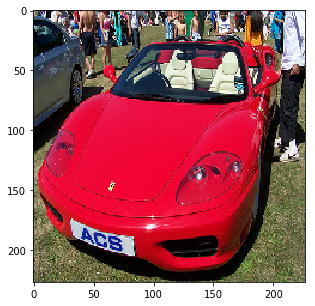

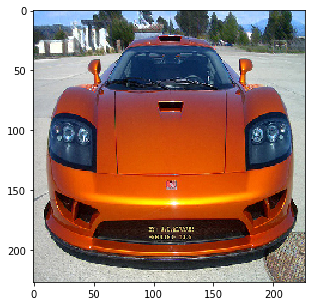

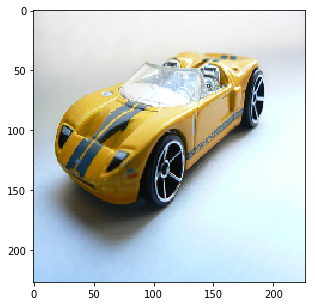

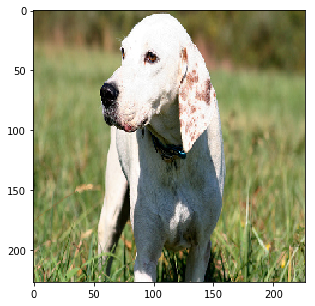

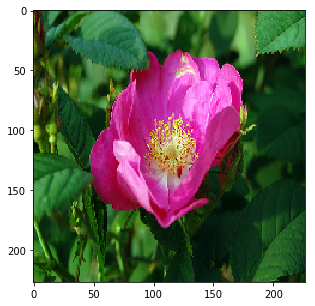

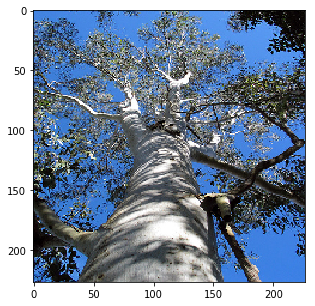

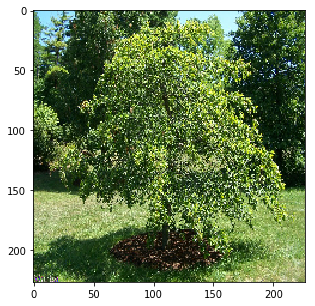

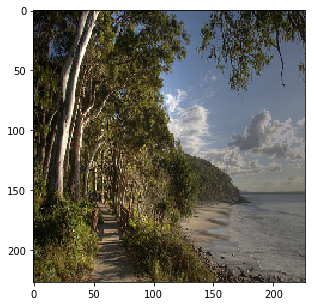

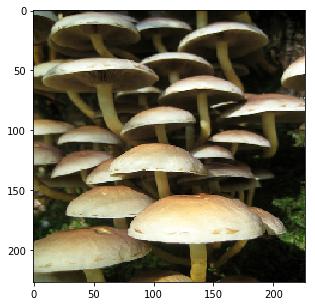

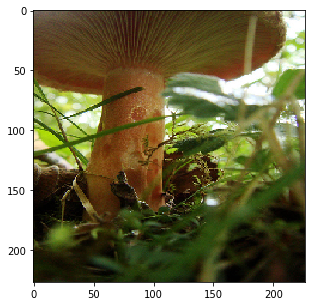

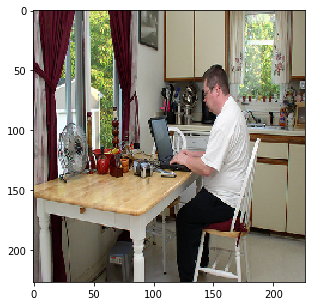

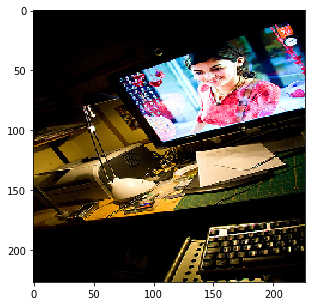

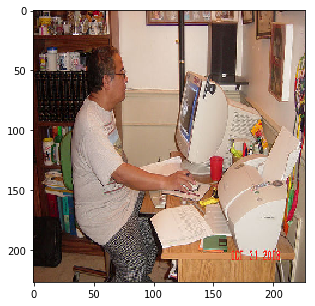

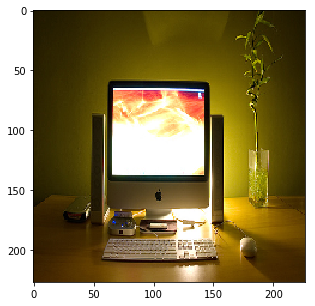

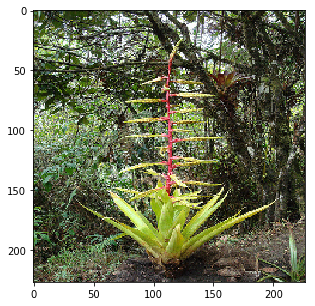

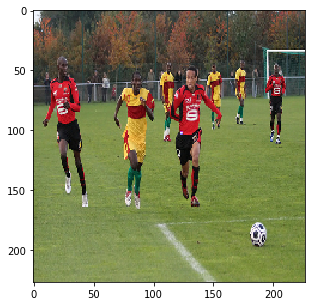

In [33]:
imgList, fileNames = readImagesFromDir('./images')
plotImages(imgList)

In [34]:
# prepare the image for ResNet50
processed_images = np.array([preprocess_input(img.copy()) for img in imgList])

# get the predicted probabilities for each class
predictions = squeezeNetModel.predict(processed_images, verbose=0)

print("Shape of predictions --> ", predictions.shape)
print("Prediction of the first image:\n", predictions[0])

Shape of predictions -->  (17, 1000)
Prediction of the first image:
 [3.01399922e-07 7.22191307e-10 1.88072670e-06 8.20357027e-09
 5.76391024e-08 3.12084136e-09 1.39836331e-07 5.98472516e-09
 5.82518311e-10 3.05473424e-09 2.14515383e-09 7.26751681e-09
 2.67692393e-08 6.26376062e-09 1.18019035e-08 3.24827010e-09
 3.23695843e-07 4.13981098e-08 1.16339280e-07 3.00736502e-08
 4.27564428e-10 3.89909172e-09 9.59669144e-09 2.33959785e-08
 3.31602662e-10 1.50645621e-10 5.53573354e-10 6.37072783e-10
 3.27094418e-09 1.36862899e-09 6.74945988e-10 6.29090058e-10
 3.63044550e-09 1.76898696e-09 3.57422181e-09 6.24576724e-10
 5.65308369e-08 6.28169516e-09 3.36588468e-09 5.37447375e-09
 2.96823055e-09 2.12262230e-09 1.37348510e-09 7.90072630e-09
 6.15555695e-09 3.62931019e-09 3.18658522e-09 2.22363217e-09
 5.17296449e-11 4.65617905e-10 9.24384658e-09 1.22314008e-08
 4.66789885e-10 6.31542907e-09 1.21594246e-09 5.82982621e-11
 5.72133807e-09 1.26216038e-10 4.87747509e-10 3.93010541e-10
 2.45431515e-08 

40960/35363 [==================================] - 0s 11us/step
Image  01 :     boxing.jpg


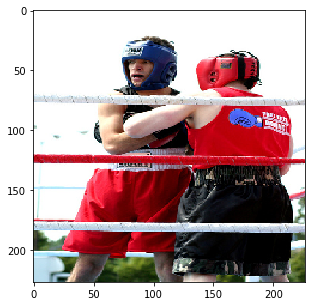

drum 0.4544368
ping-pong_ball 0.196424
paddle 0.053447556
bobsled 0.036505047
stretcher 0.03625096


Image  02 :     car1.jpg


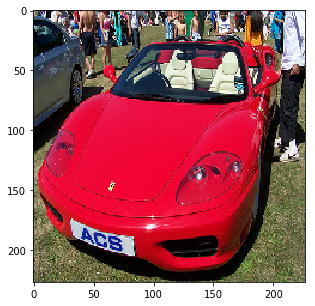

sports_car 0.7365837
convertible 0.2068125
racer 0.039597236
amphibian 0.009168112
grille 0.001670115


Image  03 :     car2.jpg


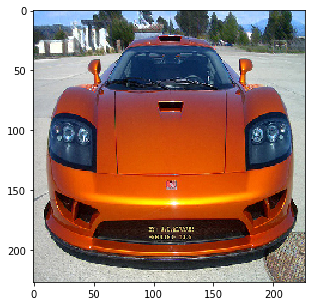

sports_car 0.59342873
convertible 0.2551108
minivan 0.039581556
pickup 0.036399335
grille 0.031402137


Image  04 :     car3.jpg


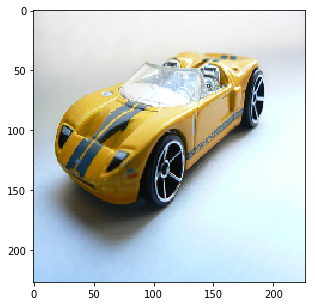

sports_car 0.55319947
racer 0.3129929
car_wheel 0.08061584
cab 0.015677864
beach_wagon 0.0101542175


Image  05 :     dog1.jpg


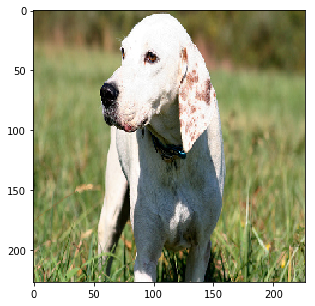

Bedlington_terrier 0.8432176
Labrador_retriever 0.0778796
American_Staffordshire_terrier 0.039848387
whippet 0.01359362
Great_Dane 0.0039363843


Image  06 :     flower.jpg


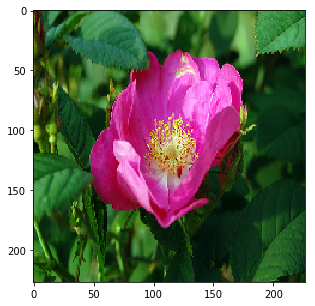

daisy 0.47438055
bee 0.08669782
hip 0.08416418
ant 0.03901454
cabbage_butterfly 0.037187763


Image  07 :     forest1.jpg


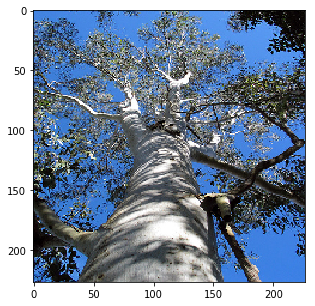

totem_pole 0.4822595
vulture 0.102865785
fountain 0.08967015
stupa 0.054897442
water_bottle 0.04006872


Image  08 :     forest3.jpg


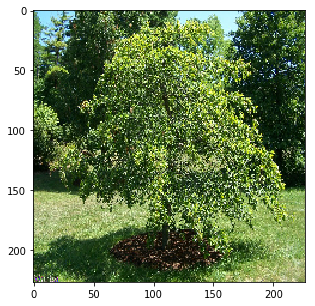

maze 0.56463087
rapeseed 0.12303063
valley 0.04214667
stone_wall 0.035888802
broccoli 0.02963175


Image  09 :     forest5.jpg


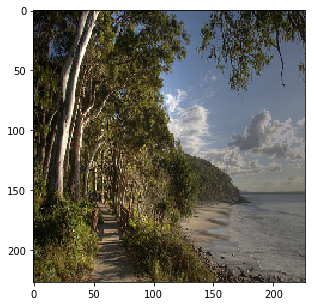

valley 0.14811559
lakeside 0.13636059
suspension_bridge 0.123784006
swing 0.055693295
seashore 0.04128891


Image  10 :     funghi2.jpg


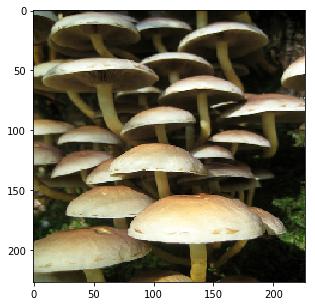

mushroom 0.56938726
hen-of-the-woods 0.4062147
agaric 0.017852869
bolete 0.005671095
wooden_spoon 0.00027554424


Image  11 :     funghi.jpg


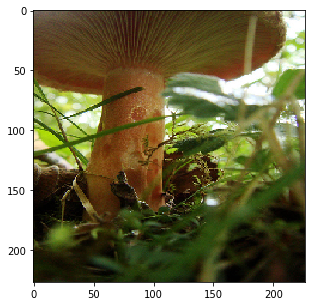

mushroom 0.15553822
patas 0.123158954
lesser_panda 0.09793333
robin 0.08781317
proboscis_monkey 0.08606249


Image  12 :     pc1.jpg


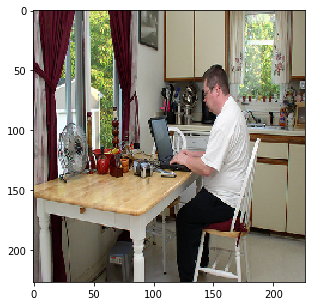

restaurant 0.48290113
dining_table 0.42938894
patio 0.01486378
grand_piano 0.01454449
marimba 0.0064715208


Image  13 :     pc3.jpg


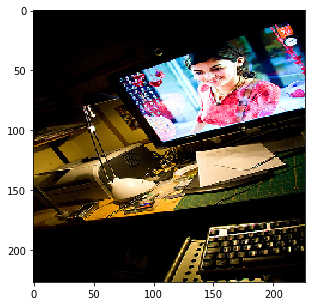

scoreboard 0.34652495
comic_book 0.13514887
carton 0.05944886
mousetrap 0.045864537
oscilloscope 0.04183779


Image  14 :     pc4.jpg


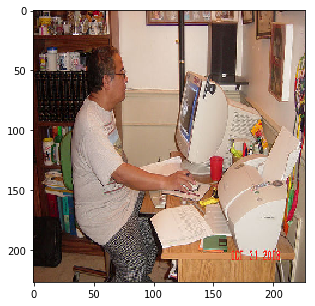

shoe_shop 0.17835823
sewing_machine 0.09017145
restaurant 0.07791002
paper_towel 0.07423968
toilet_tissue 0.03671438


Image  15 :     pc.jpg


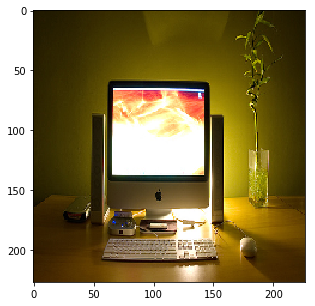

desk 0.6274197
monitor 0.1573456
desktop_computer 0.15094794
screen 0.046651203
home_theater 0.0042909672


Image  16 :     plant.jpg


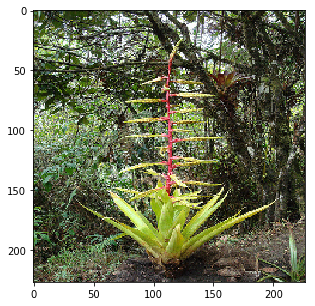

bow 0.18985431
maypole 0.13409561
chainlink_fence 0.093391426
picket_fence 0.08483072
birdhouse 0.04138706


Image  17 :     soccer.jpg


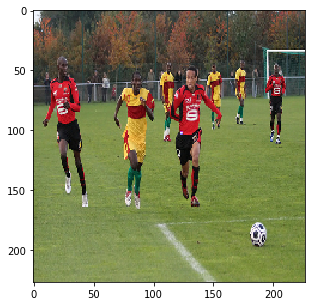

soccer_ball 0.9750558
rugby_ball 0.0178394
football_helmet 0.0022607604
volleyball 0.0015843759
croquet_ball 0.0012404023




In [35]:
# Convert the probabilities to class labels
# We will get top 5 predictions which is the default
imagePredictions = decode_predictions(predictions)
i = 0
for pred in imagePredictions:
    print("Image ", str(i+1).zfill(2), ":    ", fileNames[i])
    plotImage(imgList[i])
    for possibleClass in pred:
        print(possibleClass[1], possibleClass[2])
    print("\n")
    i+=1

# References
- SqueezeNet definition from [here](https://github.com/rcmalli/keras-squeezenet);